# Generative Medical Image Segmentation

In [275]:
# --- Import Libraries ---
import os
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from PIL import Image
from sklearn.model_selection import train_test_split
from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO
from pyro.optim import Adam
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

# Define device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"


# --- Set Plot Style ---
sns.set_style("dark")
plt.style.use("dark_background")

# --- Define Parameters ---
BATCH_SIZE = 64
IMG_SIZE = 64
NUM_WORKERS = 0


In [276]:
# --- LOAD DATA ---
data_path = "data/" # Path to the data folder

# Define image paths
data = []

for dir_ in os.listdir(data_path):
    dir_path = os.path.join(data_path, dir_)
    if os.path.isdir(dir_path):
        for filename in os.listdir(dir_path):
            img_path = os.path.join(dir_path, filename)
            data.append([dir_, img_path])
    else:
        print(f"This is not an image folder: {dir_path}")


This is not an image folder: data/.DS_Store
This is not an image folder: data/data.csv
This is not an image folder: data/README.md


In [277]:
# --- Create image and mask paths ---
df = pd.DataFrame(data, columns=["dir_name", "image_path"])

df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

imgs = sorted(df_imgs["image_path"].values, key = lambda x: int(x.split("_")[-1].split(".")[0]))
masks = sorted(df_masks["image_path"].values, key = lambda x: int(x.split("_")[-2]))

# --- Create final dataframe ---
df_final = pd.DataFrame()
df_final["image_path"] = imgs
df_final["mask_path"] = masks

# Create new column for diagnosis
def diagnosis(mask_path):
    """
    Function to determine the diagnosis based on the mask.
    If the mask is empty (all zeros), the diagnosis is 0.
    If the mask contains any non-zero values, the diagnosis is 1.
    """
    
    if np.max(cv2.imread(mask_path)) == 0:
        return 0
    else:
        return 1
    
df_final["diagnosis"] = df_final["mask_path"].apply(diagnosis)

In [278]:
# --- Define Dataset ---
class MRIDataset(Dataset):
    def __init__(self, df, img_transform=None, mask_transform=None):
        self.df = df
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]["image_path"]
        mask_path = self.df.iloc[idx]["mask_path"]

        # Load image in grayscale
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # shape (H, W)

        # Convert to PIL Image (mode 'L' = 8-bit pixels, black and white)
        image = Image.fromarray(image).convert("L")
        mask = Image.fromarray(mask).convert("L")

        # Apply transforms
        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask
    
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()  # Converts to shape [1, H, W] automatically for grayscale
])

mask_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()  # Also gives [1, H, W], useful for segmentation
])



### Split Data into Training, Test Sets

In [279]:
# Split the data into training and validation sets
train_df, test_df = train_test_split(df_final, test_size=0.1, random_state=42, stratify=df_final["diagnosis"])

# Create datasets
train_dataset = MRIDataset(train_df, img_transform=img_transforms, mask_transform=mask_transforms)
test_dataset = MRIDataset(test_df, img_transform=img_transforms, mask_transform=mask_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

print(train_dataset[0][0].shape)

Number of training samples: 3536
Number of test samples: 393
torch.Size([1, 64, 64])


### Vizualize MRI images and Masks

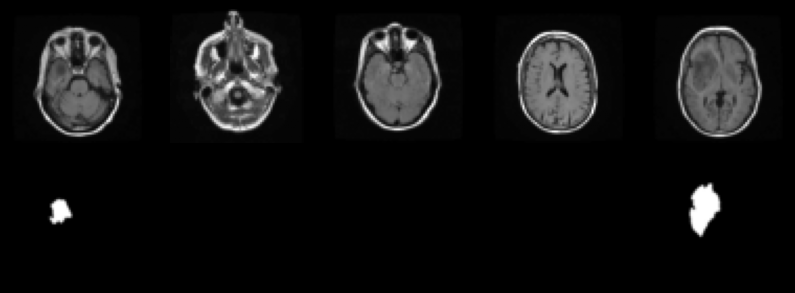

In [280]:
# --- Visualize some images and masks ---
def visualize_data(loader, num_images=5):
    images, masks = next(iter(loader))
    images = images.numpy()
    masks = masks.numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(10, 20))
    for i in range(num_images):
        axes[0, i].imshow(images[i].transpose(1, 2, 0), cmap='gray')
        axes[0, i].axis("off")
        axes[1, i].imshow(masks[i].transpose(1, 2, 0), cmap='gray')
        axes[1, i].axis("off")
    plt.subplots_adjust(hspace=-0.9)
    plt.show()

visualize_data(train_loader)

### Define Model

In [281]:
# --- Define Encoder ---
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim = IMG_SIZE*IMG_SIZE*3):

        super().__init__()
        import numpy as np
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent = z_dim
        hid_channels = 32
        self.img_size = (1, 64, 64)
        kernel = 4
        self.reshape = (hid_channels, kernel, kernel)
        in_chan = self.img_size[0]

        cnn_kwargs = dict(stride=2, padding=1)
        self.conv1 = nn.Conv2d(in_chan, hid_channels, kernel, **cnn_kwargs)
        self.conv2 = nn.Conv2d(hid_channels, hid_channels, kernel, **cnn_kwargs)
        self.conv3 = nn.Conv2d(hid_channels, hid_channels, kernel, **cnn_kwargs)

        if self.img_size[1] == self.img_size[2] == 64:
            self.conv_64 = nn.Conv2d(hid_channels, hid_channels, kernel, **cnn_kwargs)


        # setup the three linear transformations used
        self.fc1 = nn.Linear(np.prod(self.reshape), self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)

        self.mean_var = nn.Linear(self.hidden_dim, self.latent * 2)


    def forward(self, x):
  # Convolutional layers with ReLu activations
        batch_size = x.size(0)
        e1 = torch.relu(self.conv1(x))
        e2 = torch.relu(self.conv2(e1))
        e3 = torch.relu(self.conv3(e2))
        if self.img_size[1] == self.img_size[2] == 64:
            e4 = torch.relu(self.conv_64(e3))
        #x = F.leaky_relu(self.conv1(x))
        #x = F.leaky_relu(self.conv2(x))
        #x = F.leaky_relu(self.conv3(x))
        #if self.img_size[1] == self.img_size[2] == 64:
        #    x = F.leaky_relu(self.conv_64(x))
        # Fully connected layers with ReLu activations
        x = e4.view((batch_size, -1))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        #x = x.view((batch_size, -1))
        #x = F.leaky_relu(self.fc1(x))
        #x = F.leaky_relu(self.fc2(x))

        # Fully connected layer for log variance and mean
        # Log std-dev in paper (bear in mind)
        mu_logvar = self.mean_var(x)
        mu, logvar = mu_logvar.view(-1, self.latent, 2).unbind(-1)

        return mu, logvar, [e1, e2, e3]
    
# --- Define Decoder ---
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        import numpy as np
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.img_size = (1, 64, 64)
        hid_channels = 32
        kernel = 4
        self.reshape = (hid_channels, kernel, kernel)
        in_chan = self.img_size[0]

        # Linear layers
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, np.prod(self.reshape))

        # ConvTranspose2d (adjust input channels to match skip connection concatenation)
        cnn_kwargs = dict(stride=2, padding=1)

        self.up1 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel, **cnn_kwargs)         # No skip
        self.up2 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel, **cnn_kwargs)  # + e3
        self.up3 = nn.ConvTranspose2d(hid_channels, hid_channels, kernel, **cnn_kwargs)  # + e2
        self.up4 = nn.ConvTranspose2d(hid_channels, in_chan, kernel, **cnn_kwargs)       # + e1

        # 1x1 convs to align encoder skip features to decoder features if needed
        self.align_e3 = nn.Conv2d(hid_channels, hid_channels, 1)
        self.align_e2 = nn.Conv2d(hid_channels, hid_channels, 1)
        self.align_e1 = nn.Conv2d(hid_channels, hid_channels, 1)

    def forward(self, z, skips):
        batch_size = z.size(0)
        x = torch.relu(self.fc1(z))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = x.view(batch_size, *self.reshape)

        x = torch.relu(self.up1(x))  # → 8x8

        e3 = F.interpolate(skips[2], size=x.shape[2:], mode='nearest')
        e3 = self.align_e3(e3)
        x = torch.relu(self.up2(x + e3))  # → 16x16

        e2 = F.interpolate(skips[1], size=x.shape[2:], mode='nearest')
        e2 = self.align_e2(e2)
        x = torch.relu(self.up3(x + e2))  # → 32x32

        e1 = F.interpolate(skips[0], size=x.shape[2:], mode='nearest')
        e1 = self.align_e1(e1)
        x = torch.sigmoid(self.up4(x + e1))  # → 64x64

        return x


In [282]:
# --- Define VAE ---
class VAE(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=256, input_dim=IMG_SIZE*IMG_SIZE*3):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = input_dim  # Assuming output is same as input for reconstruction

        # Define the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, self.input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, self.output_dim)
        self.z_dim = z_dim

    # Define the model p(y|z)p(z)
    def model(self, x, y, beta = 8):
        pyro.module("decoder", self.decoder)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=device)
            skips = [torch.zeros(x.shape[0], 32, 16, 16, dtype=x.dtype, device=device) for _ in range(3)]
            # sample from prior
            with pyro.poutine.scale(scale=beta):
                # sample the latent code z from the prior p(z)
                z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode the latent code z
            out = self.decoder.forward(z, skips)
            # sample from the decoder p(y|z)
            pyro.sample("obs", dist.Bernoulli(out, validate_args=False).to_event(3), obs=y)

            return out

    # Define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x, y, beta = 8):
        # use the encoder to get the parameters used to define q(z|x)
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            with pyro.poutine.scale(scale=beta):
                # get the parameters of the variational distribution q(z|x)
                z_loc, z_scale, _ = self.encoder.forward(x)
                z_scale = torch.exp(z_scale * 0.5)  # Convert log variance to standard deviation
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))



In [283]:
def train(svi, train_loader):
    # initialize loss accumulator
    epoch_loss = 0.

    for img, mask in train_loader:

        # move data to device
        img = img.to(device)
        mask = mask.to(device)
    
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(img, mask)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train



def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for img, mask in test_loader:
        # move data to device
        img = img.to(device)
        mask = mask.to(device)
        
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(img, mask)  
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [284]:
print(train_loader.dataset[0][0].shape)
print(train_loader.dataset[1][1].shape)


torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [285]:
# --- Training the VAE ---
num_epochs = 20
test_frequency = 5
lr = 1e-3

def run_model(num_epochs=num_epochs, test_frequency=test_frequency, lr=lr):
    pyro.clear_param_store()  # clear everything before instantiation
    vae = VAE(z_dim = 64, hidden_dim=248, input_dim=IMG_SIZE*IMG_SIZE*3)
    vae.to(device)

    # setup the optimizer
    optimizer = Adam({"lr": lr})
    svi = SVI(vae.model, vae.guide, optimizer, loss=pyro.infer.Trace_ELBO())

    train_elbo = []
    test_elbo = []
    # training loop
    for epoch in range(num_epochs):
        total_epoch_loss_train = train(svi, train_loader)
        train_elbo.append(-total_epoch_loss_train)
        print(f"[Epoch {epoch+1}]")
        print("Mean train loss: %.4f" %  total_epoch_loss_train)

        if epoch % test_frequency == 0:
            # report test diagnostics
            total_epoch_loss_test = evaluate(svi, test_loader)
            test_elbo.append(-total_epoch_loss_test)
            print("Mean test loss: %.4f" % total_epoch_loss_test)
        print("")
    return vae

vae = run_model(num_epochs=num_epochs, test_frequency=test_frequency, lr=lr)

[Epoch 1]
Mean train loss: 1533.8188
Mean test loss: 682.7513

[Epoch 2]
Mean train loss: 674.3263

[Epoch 3]
Mean train loss: 663.1813

[Epoch 4]
Mean train loss: 660.8363

[Epoch 5]
Mean train loss: 659.3226

[Epoch 6]
Mean train loss: 657.8890
Mean test loss: 644.5732

[Epoch 7]
Mean train loss: 654.8557

[Epoch 8]
Mean train loss: 652.0574

[Epoch 9]
Mean train loss: 651.7528

[Epoch 10]
Mean train loss: 645.4141

[Epoch 11]
Mean train loss: 642.2249
Mean test loss: 629.3931

[Epoch 12]
Mean train loss: 638.2502

[Epoch 13]
Mean train loss: 638.2546

[Epoch 14]
Mean train loss: 641.7652

[Epoch 15]
Mean train loss: 636.7441

[Epoch 16]
Mean train loss: 632.6482
Mean test loss: 622.0166

[Epoch 17]
Mean train loss: 631.4600

[Epoch 18]
Mean train loss: 628.8636

[Epoch 19]
Mean train loss: 625.6049

[Epoch 20]
Mean train loss: 621.9505



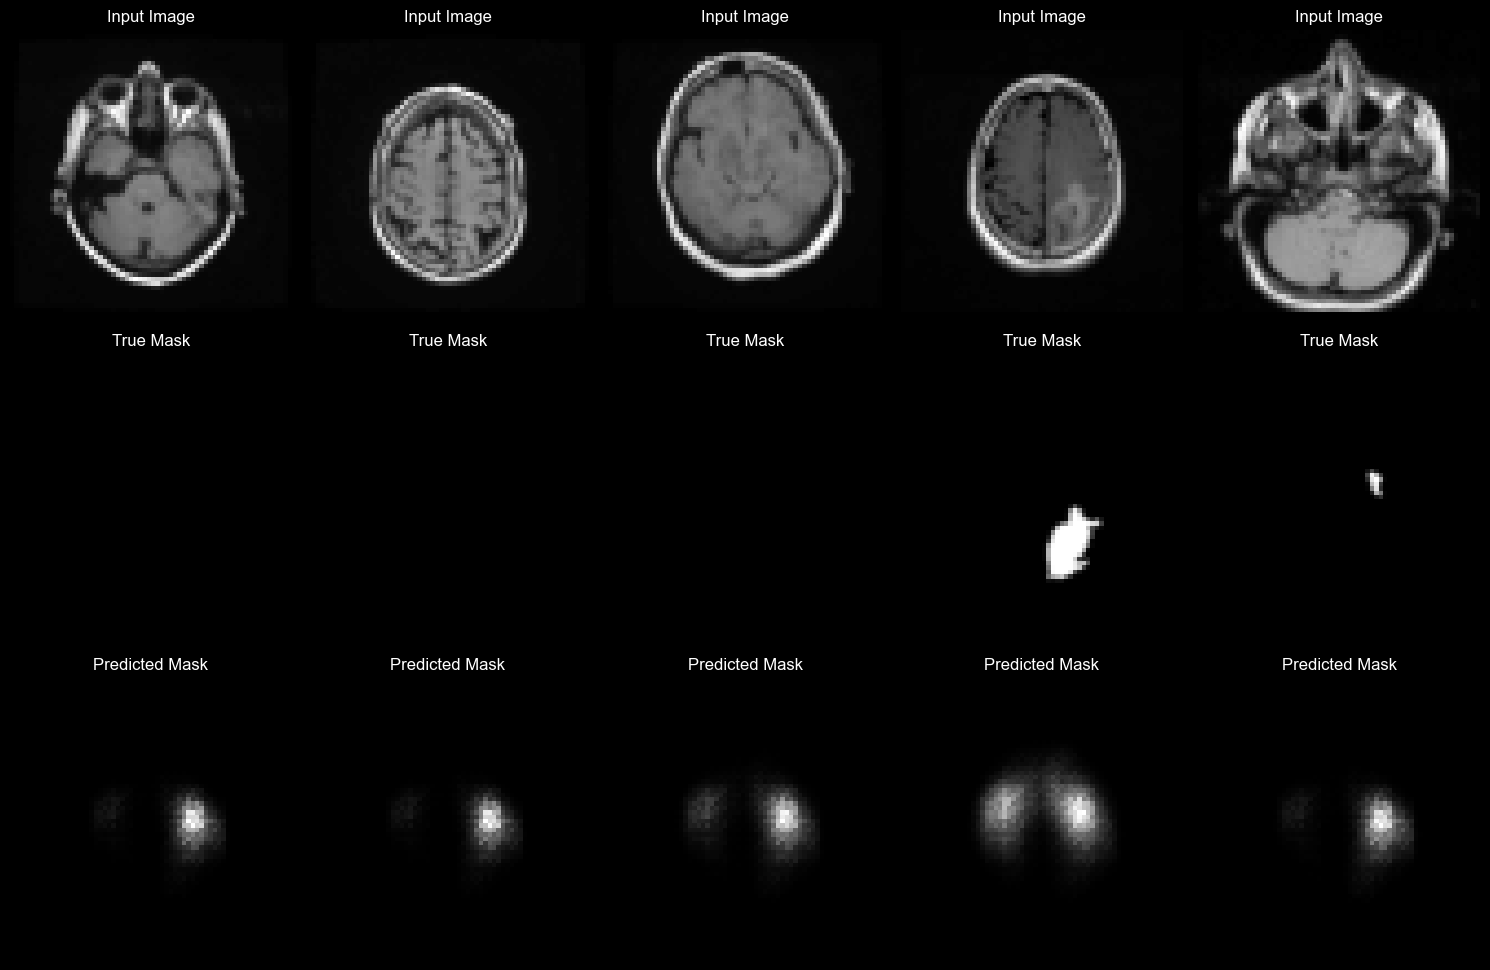

In [290]:
def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)
    with torch.no_grad():
        # Get model predictions and reshape to the mask dimensions
        pred = model.model(images, true_masks)
    # Reshape predictions to match the true mask shape
    pred = pred.reshape(true_masks.size()).cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()
    
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
         # Show input image
         axes[0, i].imshow(images[i+24].transpose(1, 2, 0), cmap='gray')
         axes[0, i].set_title("Input Image")
         axes[0, i].axis("off")
         # Show true mask (using grayscale for clarity)
         axes[1, i].imshow(true_masks[i+24].transpose(1, 2, 0), cmap='gray')
         axes[1, i].set_title("True Mask")
         axes[1, i].axis("off")
         # Show predicted mask (using grayscale for clarity)
         axes[2, i].imshow(pred[i+24].transpose(1, 2, 0), cmap='gray')
         axes[2, i].set_title("Predicted Mask")
         axes[2, i].axis("off")
    plt.tight_layout()
    plt.show()


visualize_predictions(vae, test_loader)


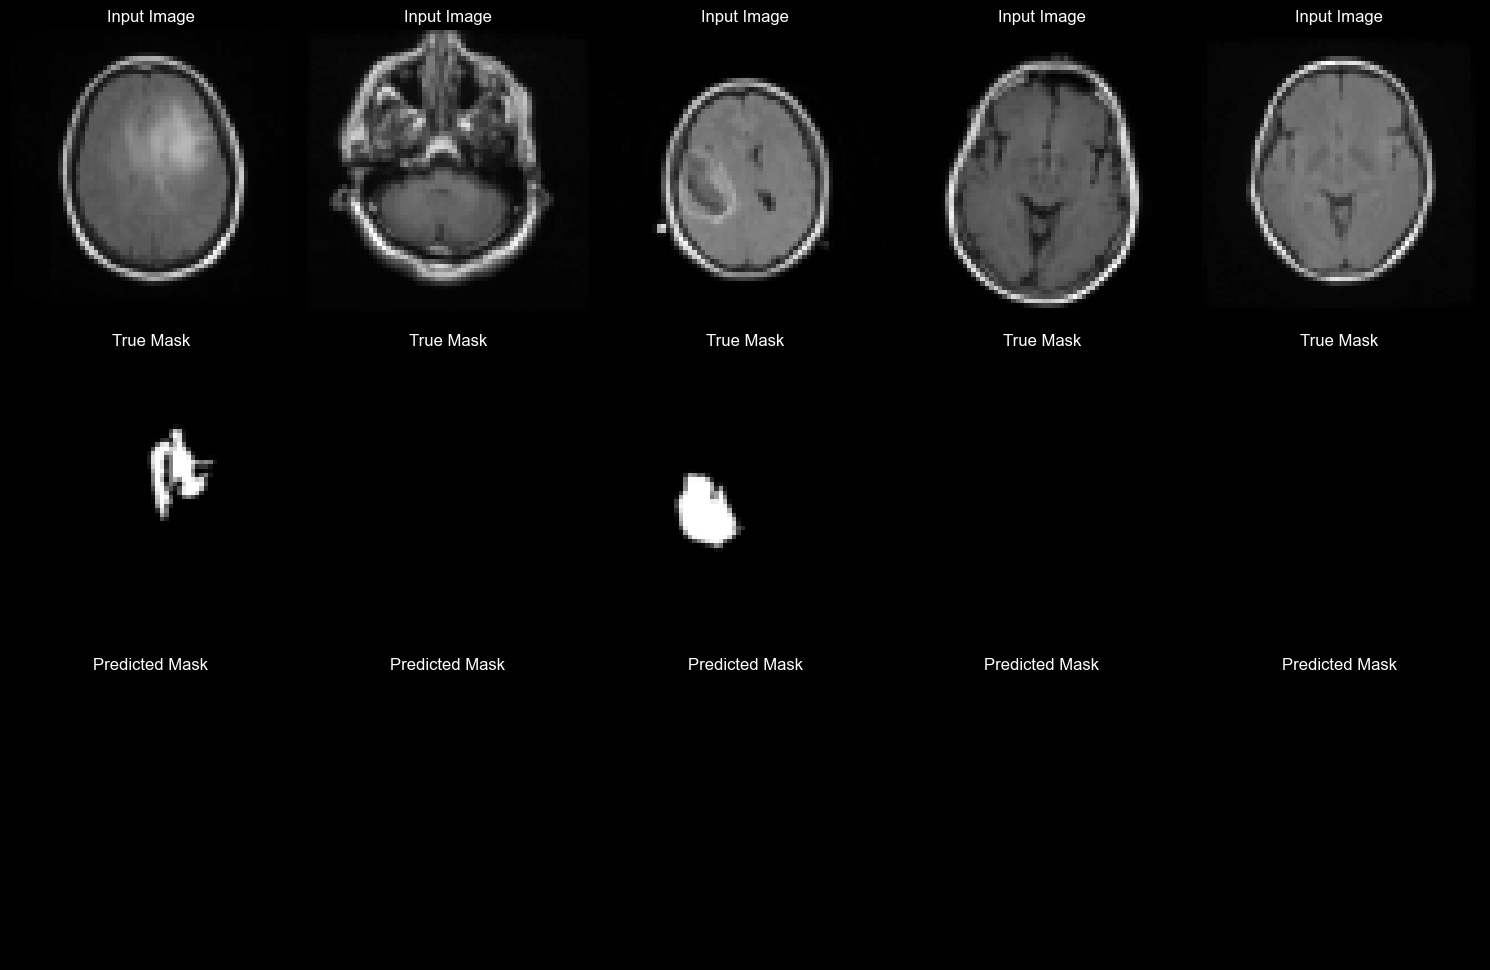

In [287]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    images, true_masks = next(iter(loader))
    images = images.to(device)
    true_masks = true_masks.to(device)

    with torch.no_grad():
        # Get model predictions
        pred = model.model(images, true_masks)

    # Binarize predictions
    pred_binary = (pred > 0.2).float()

    # Move tensors to CPU and convert to numpy
    pred_binary = pred_binary.cpu().numpy()
    true_masks = true_masks.cpu().numpy()
    images = images.cpu().numpy()

    # Plot
    fig, axes = plt.subplots(3, num_images, figsize=(15, 10))
    for i in range(num_images):
        # Input image
        axes[0, i].imshow(images[i].transpose(1, 2, 0), cmap ='gray')
        axes[0, i].set_title("Input Image")
        axes[0, i].axis("off")

        # True mask
        axes[1, i].imshow(true_masks[i].transpose(1, 2, 0), cmap='gray')
        axes[1, i].set_title("True Mask")
        axes[1, i].axis("off")

        # Predicted binary mask
        axes[2, i].imshow(pred_binary[i].transpose(1, 2, 0), cmap='gray')
        axes[2, i].set_title("Predicted Mask")
        axes[2, i].axis("off")

    plt.tight_layout()
    plt.show()
visualize_predictions(vae, test_loader, num_images=5)
